# Load the Dataset

First, load the training and testing data into Pandas DataFrames.

In [ ]:
import pandas as pd

# Load datasets
train_path = "/content/Poem_classification - train_data.csv"
test_path = "/content/Poem_classification - test_data.csv"

df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

# Display first few rows
print("Train Dataset:")
print(df_train.head())

print("\nTest Dataset:")
print(df_test.head())


Train Dataset:
   Genre                                               Poem
0  Music                                                NaN
1  Music                In the thick brushthey spend the...
2  Music     Storms are generous.                       ...
3  Music   —After Ana Mendieta Did you carry around the ...
4  Music   for Aja Sherrard at 20The portent may itself ...

Test Dataset:
   Genre                                               Poem
0  Music  A woman walks by the bench I’m sitting onwith ...
1  Music  Because I am a boy, the untouchability of beau...
2  Music  Because today we did not leave this world,We n...
3  Music  Big Bend has been here, been here. Shouldn’t i...
4  Music  I put shells there, along the lip of the road....


# Check Dataset Structure

## 1-Check for missing values and column names.

In [ ]:
print(df_train.info())

print('**********************************************')
print(df_test.info())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 841 entries, 0 to 840
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Genre   841 non-null    object
 1   Poem    837 non-null    object
dtypes: object(2)
memory usage: 13.3+ KB
None
**********************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Genre   150 non-null    object
 1   Poem    150 non-null    object
dtypes: object(2)
memory usage: 2.5+ KB
None


In [ ]:
# Check for missing values
print(df_train.isnull().sum())
print(df_test.isnull().sum())


Genre    0
Poem     4
dtype: int64
Genre    0
Poem     0
dtype: int64


## 2-Handle Missing Values

In [ ]:
# Drop rows with missing poems
df_train = df_train.dropna(subset=['Poem'])

# Check again for missing values
print(df_train.isnull().sum())


Genre    0
Poem     0
dtype: int64


## 3- Clean the Text Data

We'll preprocess the poems by:

Lowercasing

Removing punctuation

Removing stopwords

In [ ]:
import re
import nltk
from nltk.corpus import stopwords

# Download stopwords (if not already downloaded)
nltk.download('stopwords')

# Get stopwords list
stop_words = set(stopwords.words('english'))

# Function to clean text
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\W', ' ', text)  # Remove punctuation
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    text = ' '.join(word for word in text.split() if word not in stop_words)  # Remove stopwords
    return text.strip()

# Apply cleaning to both datasets
df_train['cleaned_text'] = df_train['Poem'].astype(str).apply(clean_text)
df_test['cleaned_text'] = df_test['Poem'].astype(str).apply(clean_text)

# Display first few cleaned rows
print(df_train[['Poem', 'cleaned_text']].head())


                                                Poem  \
1                In the thick brushthey spend the...   
2     Storms are generous.                       ...   
3   —After Ana Mendieta Did you carry around the ...   
4   for Aja Sherrard at 20The portent may itself ...   
5   for Bob Marley, Bavaria, November 1980 Here i...   

                                        cleaned_text  
1  thick brushthey spend hottest part day soaking...  
2  storms generous something easy surrender sitti...  
3  ana mendieta carry around matin star hold fore...  
4  aja sherrard 20the portent may memory wallace ...  
5  bob marley bavaria november 1980 brilliant mor...  


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#  Tokenize and Pad the Sequences

We will use Keras Tokenizer to convert text into sequences of integers and pad them for consistency.

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Parameters
max_words = 5000  # Maximum number of words to keep
max_len = 100     # Max length of sequences

# Initialize the Tokenizer
tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
tokenizer.fit_on_texts(df_train['cleaned_text'])

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(df_train['cleaned_text'])
X_test_seq = tokenizer.texts_to_sequences(df_test['cleaned_text'])

# Pad sequences to ensure uniform input size
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

# Print the shape of padded sequences
print("Shape of padded training data:", X_train_pad.shape)
print("Shape of padded test data:", X_test_pad.shape)


Shape of padded training data: (837, 100)
Shape of padded test data: (150, 100)


# Encode the Genre Labels

Now, we need to convert the "Genre" column into numerical labels so our machine learning model can understand them.

In [ ]:
import tensorflow as tf

# Convert genre labels to integers using TensorFlow
label_mapping = {label: idx for idx, label in enumerate(df_train['Genre'].unique())}
print("Label Mapping:", label_mapping)

# Map the labels to integer values
y_train = df_train['Genre'].map(label_mapping).values
y_test = df_test['Genre'].map(label_mapping).values

# Print the first few labels
print("First few labels:", y_train[:5])


Label Mapping: {'Music': 0, 'Death': 1, 'Affection': 2, 'Environment': 3}
First few labels: [0 0 0 0 0]


# Train a Model

## 1-Define the Model Architecture

In this step, we define the layers and architecture of the model. We'll use an Embedding Layer, followed by LSTM layers for sequence processing, and a Dense layer for classification.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# Parameters
embedding_dim = 100  # Embedding dimension
max_words = 5000     # Maximum number of words in the vocabulary
max_len = 100        # Maximum length of sequences

# Build the model
model = Sequential([
    # Embedding Layer: Converts words into dense vectors of fixed size
    Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len),

    # LSTM Layer: Learn sequential relationships
    LSTM(128, return_sequences=True),

    # Dropout Layer: Prevents overfitting by randomly setting input units to 0
    Dropout(0.2),

    # Second LSTM Layer
    LSTM(64),

    # Dense Layer: Fully connected layer to learn complex patterns
    Dense(32, activation='relu'),

    # Output Layer: For classification (number of classes)
    Dense(len(label_mapping), activation='softmax')  # Number of genres
])

# Show the model summary
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## 2-Compile the Model

Now, we need to compile the model. We specify the optimizer, loss function, and metrics.

Adam optimizer: Popular choice for training neural networks.

Sparse categorical cross-entropy loss: Suitable for multi-class classification with integer labels.

Accuracy: To evaluate the model performance.

In [ ]:
# Compile the model
model.compile(
    optimizer='adam',  # Optimizer
    loss='sparse_categorical_crossentropy',  # Loss function (multi-class classification)
    metrics=['accuracy']  # Metrics to track
)


## 3-Train the Model

Next, we train the model using the training data. We'll specify the number of epochs (iterations over the entire dataset) and the batch size (how many samples to process before updating the model).

In [ ]:
# Train the model
history = model.fit(
    X_train_pad,  # Training data (padded sequences)
    y_train,      # Training labels
    epochs=5,     # Number of epochs
    batch_size=32,  # Batch size
    validation_data=(X_test_pad, y_test)  # Validation data to monitor performance on unseen data
)


Epoch 1/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 210ms/step - accuracy: 0.2456 - loss: 1.3824 - val_accuracy: 0.1000 - val_loss: 1.4682
Epoch 2/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 152ms/step - accuracy: 0.4433 - loss: 1.3413 - val_accuracy: 0.1267 - val_loss: 1.6135
Epoch 3/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 165ms/step - accuracy: 0.6394 - loss: 0.9582 - val_accuracy: 0.1800 - val_loss: 1.9775
Epoch 4/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 155ms/step - accuracy: 0.7360 - loss: 0.6063 - val_accuracy: 0.2333 - val_loss: 2.5095
Epoch 5/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 206ms/step - accuracy: 0.8686 - loss: 0.4256 - val_accuracy: 0.2600 - val_loss: 2.7018


# 4-Visualize the Training Results

After plotting, you can still evaluate the model on the test dataset as we discussed earlier:

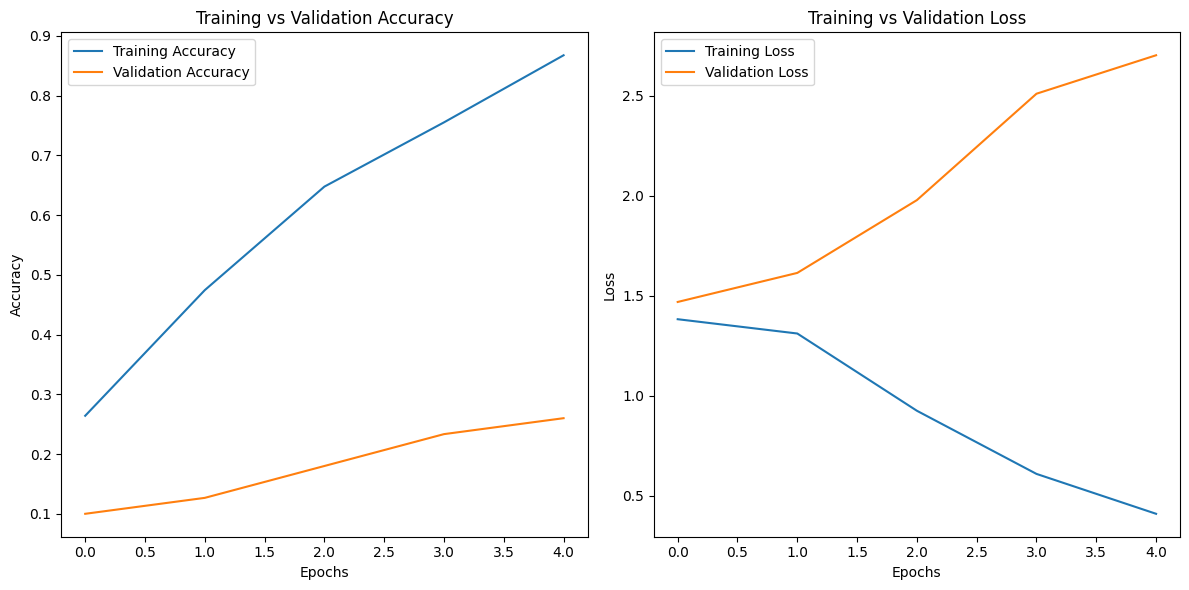

In [ ]:
import matplotlib.pyplot as plt

# Plot Training & Validation Accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # (rows, columns, position)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Training & Validation Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

# 5-Final Evaluation on Test Data

In [ ]:
# Evaluate the model on the test data
loss, accuracy = model.evaluate(X_test_pad, y_test)

# Print the evaluation results
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.2655 - loss: 2.6339
Test Loss: 2.7018275260925293
Test Accuracy: 0.25999999046325684
